In [1]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 606e-9
const Γ = 2π* 8.3e6
const m = @with_unit 59 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


In [2]:
function SE_collapse_pol!(integrator)
    """ 
    The previous method collapses both the excited state and the polarization of the emitted photon.
    But in reality, we should collapse something iff the information is leaked into the environment, which, in our case
    does NOT include the identity of the excited state, no matter what you choose to measure.
    
    The current approach assumes the environment measures the polarization of the photon along z. We do not collapse which 
    excited state the molecule is in, therefore preserving some coherence (the state after collapse can be a superposition
    of different ground states).
    
    And because phase information between excited states is preserved during collapse, we can not sample based on average 
    excited state population anymore.
    
    See Dalibard, Castin & Molmer PRL 1992
    """ 
    n_states = length(integrator.p.states)
    n_excited = integrator.p.extra_p.n_excited
    n_ground = n_states - n_excited
    dT = integrator.p.extra_p.dT
    d = integrator.p.d
    ψ = integrator.u
    
    # save_every = 10000, save_counter = 0, trajectory = []
    extra_p = integrator.p.extra_p
    extra_p.save_counter += 1
    if extra_p.save_counter >= extra_p.save_every
       push!(extra_p.trajectory, deepcopy(integrator.u))
        extra_p.save_counter = 0
    end
    
    p_decay = 0
    for i in 1:n_excited
        p_decay += norm(ψ[n_ground + i])^2 * dT
    end
    
    rn = rand()
    if rn > p_decay
        # No photon is observed. Coherent population by H_eff.
        return nothing
    end
    
    # A photon is observed.
    # Measure the polarization of the photon along z.
    p⁺ = 0
    p⁰ = 0
    p⁻ = 0
    
    for i in 1:n_excited
        # p⁺ += norm(ψ[n_states + i])^2 * sum(norm.(d[:,i,1]).^2)
        # p⁰ += norm(ψ[n_states + i])^2 * sum(norm.(d[:,i,2]).^2)
        # p⁻ += norm(ψ[n_states + i])^2 * sum(norm.(d[:,i,3]).^2)
        p⁺ += norm(ψ[n_ground + i])^2 * sum(norm.(d[:,n_ground+i,1]).^2)
        p⁰ += norm(ψ[n_ground + i])^2 * sum(norm.(d[:,n_ground+i,2]).^2)
        p⁻ += norm(ψ[n_ground + i])^2 * sum(norm.(d[:,n_ground+i,3]).^2)
        
        # note the polarization p in d[:,:,p] is defined to be m_e - m_g, 
        # whereas the polarization of the emitted photon is m_g - m_e
    end
    
    p_norm = p⁺ + p⁰ + p⁻
    rn = rand() * p_norm
    ψ[1:n_ground] .= 0 # zero ground state amplitudes
    
    pol = 0
    if 0 < rn <= p⁺ # photon is measured to have polarization σ⁺
        pol = 1
    elseif p⁺ < rn <= p⁺ + p⁰ # photon is measured to have polarization σ⁰
        pol = 2
    else # photon is measured to have polarization σ⁻
        pol = 3
    end
    
    for i in 1:n_ground
        for j in (n_ground+1):n_states
            ψ[i] += ψ[j] * d[i,j,pol]
        end
    end
    # ψ[n_ground + 1:n_states] .= 0
    ψ[(n_ground + 1):n_states] .= 0 # zero excited state amplitudes
    ψ[(n_states + 1):n_excited] .= 0 # zero excited state populations
    
    ψ_norm = 0.0
    for i ∈ 1:n_states
        ψ_norm += norm(ψ[i])^2
    end
    ψ_norm = sqrt(ψ_norm)
    for i ∈ 1:n_states
        ψ[i] /= ψ_norm
    end
    
    integrator.p.n_scatters += 1
    
     # reset excited state population accumulation
#     integrator.u[n_states + 1: n_states + n_excited] .= 0
    
#     for i in 1:n_states
#         integrator.p.populations[i] = norm(integrator.u[i])^2
#     end
    
    dp = sample_direction(1)
    dv = dp ./ integrator.p.mass
    integrator.u[n_states + n_excited + 4] += dv[1]
    integrator.u[n_states + n_excited + 5] += dv[2]
    integrator.u[n_states + n_excited + 6] += dv[3]
    

    
end
 
function spontaneous_emission_event(p, i_excited)
    """ 
        Excited state i_excited sponatneously emits. Randomly sample which ground state it decays into, 
        return the ground state index and change in m_F (which is relevant in determining the direction of
        momentum kick).
        
    """
    n_states = length(p.states)
    
    transition_probs = norm.(p.d[:,i_excited,:]).^2
    w = weights(transition_probs)
    i = sample(w)
    δm = -((i-1)÷n_states - 2)
    i_ground = (i-1) % n_states + 1
    # @printf("decay from %i to %i", i_excited, i_ground)
    # println()

    return (i_ground, δm)
end;

using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

function update_H(H, p, r, τ)
    Zeeman_Hx = p.extra_p.Zeeman_Hx
    Zeeman_Hy = p.extra_p.Zeeman_Hy
    Zeeman_Hz = p.extra_p.Zeeman_Hz
    gradient_z = p.extra_p.gradient_z
    gradient_x = p.extra_p.gradient_x
    gradient_y = p.extra_p.gradient_y
    @turbo for i in eachindex(H)
#         H.re[i] = gradient_x * Zeeman_Hx.re[i] + gradient_y * Zeeman_Hy.re[i]  + gradient_z * Zeeman_Hz.re[i] 
#         H.im[i] = gradient_x * Zeeman_Hx.im[i]  + gradient_y * Zeeman_Hy.im[i]  + gradient_z * Zeeman_Hz.im[i] 
    
        H.re[i] = gradient_x * Zeeman_Hx.re[i] * r[1] + gradient_y * Zeeman_Hy.re[i] * r[2] + gradient_z * Zeeman_Hz.re[i] * r[3]
        H.im[i] = gradient_x * Zeeman_Hx.im[i] * r[1] + gradient_y * Zeeman_Hy.im[i] * r[2] + gradient_z * Zeeman_Hz.im[i] * r[3]
    end
    return nothing
end

function randomize_initial_vector!(p, r_dist, v_dist)
    n_excited = extra_p.n_excited
    n_states = length(p.states)
    p.ψ[n_states + n_excited + 1] = rand(r_dist)*k
    p.ψ[n_states + n_excited + 2] = rand(r_dist)*k
    p.ψ[n_states + n_excited + 3] = rand(r_dist)*k
    p.ψ[n_states + n_excited + 4] = rand(v_dist)*k/Γ
    p.ψ[n_states + n_excited + 5] = rand(v_dist)*k/Γ
    p.ψ[n_states + n_excited + 6] = rand(v_dist)*k/Γ
end
;

In [3]:
import QuantumStates.extend_operator
function extend_operator(operator::T, state::State, state′::State, args...) where {T}
    val = zero(ComplexF64)
    for (i, basis_state) in enumerate(state.basis)
        for (j, basis_state′) in enumerate(state′.basis)
            val += conj(state.coeffs[i]) * state′.coeffs[j] * operator(basis_state, basis_state′, args...)
            # coeff1 = state.coeffs[i]
            # coeff2 = state′.coeffs[i]
            # if (norm(coeff1)^2 > 1e-5) && (norm(coeff1)^2 > 1e-5)
                # val += state.coeffs[i] * state′.coeffs[j] * operator(basis_state, basis_state′, args...)
            # end
        end
    end
    return val
end
# extend_operator1(Zeeman_y,states[2], states[2])

function operator_to_matrix(A, states)
    """
    Write an operator as a matrix in basis {states}.
    """
    n_states = length(states)
    A_mat = zeros(ComplexF64, n_states, n_states)
    for i in 1:n_states
        for j in 1:n_states
            A_mat[i,j] = extend_operator(A, states[i], states[j])
        end
    end
    return A_mat
end



operator_to_matrix (generic function with 1 method)

In [4]:
# import OpticalBlochEquations.update_H!
# function update_H!(p, τ, r, H₀, fields, H, E_k, ds, ds_state1, ds_state2, Js)

#     p.update_H(H, p, r, τ)
    
#     # @turbo for i in eachindex(H)
#     #     H.re[i] = H₀.re[i]
#     #     H.im[i] = H₀.im[i]
#     # end
 
#     update_fields!(fields, r, τ)

#     # Set summed fields to zero
#     p.E -= p.E
#     @inbounds for i ∈ 1:3
#         E_k[i] -= E_k[i]
#     end
    
#     # Sum updated fields
#     @inbounds for i ∈ eachindex(fields)
#         E_i = fields.E[i] * sqrt(fields.s[i]) / (2 * √2)
#         k_i = fields.k[i]
#         p.E += E_i
#         for k ∈ 1:3
#             E_k[k] += E_i * k_i[k]
#         end
#     end


#     @inbounds for q ∈ 1:3
#         E_q = p.E[q]
#         #E_q = conj(E_q) ####
#         if norm(E_q) > 1e-10
#             E_q_re = real(E_q)
#             E_q_im = imag(E_q)
#             ds_q = ds[q]
#             ds_q_re = ds_q.re
#             ds_q_im = ds_q.im
#             ds_state1_q = ds_state1[q]
#             ds_state2_q = ds_state2[q]
#             @turbo for i ∈ eachindex(ds_q)
#                 m = ds_state1_q[i] # excited state
#                 n = ds_state2_q[i] # ground state
#                 d_re = ds_q_re[i]
#                 d_im = ds_q_im[i]
#                 d_im = -d_im # take conjugate of d to make sure the Hamiltonian terms are d⋅E* + d*⋅E
#                 val_re = E_q_re * d_re - E_q_im * d_im
#                 val_im = E_q_re * d_im + E_q_im * d_re
#                 H.re[n,m] -= val_re
#                 H.im[n,m] -= val_im
#                 H.re[m,n] -= val_re
#                 H.im[m,n] += val_im
#             end
#         end
#     end

#     for J ∈ Js
#         rate = im * norm(J.r)^2 / 2
#         H[J.s, J.s] -= rate
#     end

#     return nothing
# end

In [5]:
function spherical_to_cart(vec)
   cart = [0.0+0*im,0,0].*vec[1]
    cart[1] = (vec[1]-vec[3])/sqrt(2)
    cart[2] = im * (vec[1] + vec[3])/sqrt(2)
    cart[3] = vec[2]
    return SVector{3,ComplexF64}(cart)
end

function spherical_to_cart_conj(vec)
    cart = [0.0+0*im,0,0].*vec[1]
    cart[1] = conj(vec[1]-vec[3])/sqrt(2)
    cart[2] = im * conj(vec[1] + vec[3])/sqrt(2)
    cart[3] = conj(vec[2])
    return SVector{3,ComplexF64}(cart)
end

function cart_to_spherical(vec)
    sp = [0.0+0*im,0,0].*vec[1]
    sp[1] = (vec[1] - im*vec[2])/sqrt(2)
    sp[3] = -(vec[1] + im*vec[2])/sqrt(2)
    sp[2] = vec[3]
    return SVector{3,ComplexF64}(sp)
end;

import QuantumStates.TDM
function TDM(state::AngularMomentumState_Labelled, state′::AngularMomentumState_Labelled, p::Int64)
    L,  N,  M  = unpack(state)
    L′, N′, M′ = unpack(state′)
    if L′ <= L
        return 0.0
    else
        return (
            (-1)^(N - M) * wigner3j(N, 1, N′, -M, -p, M′) * sqrt(2N′ + 1)
            # (-1)^(N - M) * wigner3j(N, 1, N′, -M, -p, M′) * sqrt(2N′ + 1)
        )
    end
end

TDM (generic function with 13 methods)

In [6]:
H_operator = :(
    T * L
)
parameters = @params begin
    T = 478e12
end

# Create basis states
QN_bounds = (L = 0, N = 0)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

evaluate!(H)
QuantumStates.solve!(H)

# Add Zeeman terms
Zeeman_x(state, state′) = (Zeeman_L1(state, state′,-1) - Zeeman_L1(state, state′,1))/sqrt(2)
Zeeman_y(state, state′) = im*(Zeeman_L1(state, state′,-1) + Zeeman_L1(state, state′,1))/sqrt(2)
Zeeman_z(state, state′) = Zeeman_L1(state, state′, 0)

H = add_to_H(H, :B_x, (gS*_μB) .* Zeeman_x)
H = add_to_H(H, :B_y, (gS*_μB) .* Zeeman_y)
H = add_to_H(H, :B_z, (gS*_μB) .* Zeeman_z)

H.parameters.B_x = 0.0
H.parameters.B_y = 0.0
H.parameters.B_z = 0.0
evaluate!(H)
QuantumStates.solve!(H)

ω = 2π * (energy(H.states[end]) - energy(H.states[1]))

H.parameters.B_x = 0.0
H.parameters.B_y = 0.0
H.parameters.B_z = 0.0
evaluate!(H)
QuantumStates.solve!(H)
states = H.states

update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
d_copy = deepcopy(d)
for j in 1:1:length(H.states)
   d[:, j, :] =  d[:, j, :]
end

# note the spherical tensor d is defined with flipped p. (T_p -> T_-p)
d_cart = deepcopy(d)
d_cart[:,:,1] = (d[:,:,3] - d[:,:,1])./sqrt(2)
d_cart[:,:,2] = im* (d[:,:,3] + d[:,:,1])./sqrt(2)
d_cart[:,:,3] = d[:,:,2]

Zeeman_x_mat = StructArray(operator_to_matrix(Zeeman_x, H.states)*(gS*_μB)./ Γ .*(2π))
Zeeman_y_mat = StructArray(operator_to_matrix(Zeeman_y, H.states)*(gS*_μB)./ Γ .*(2π))
Zeeman_z_mat = StructArray(operator_to_matrix(Zeeman_z, H.states)*(gS*_μB)./ Γ .*(2π))
;

In [7]:
display.(H.states)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 0, 0, (M = 0:0,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

State{AngularMomentumState_Labelled}(4.78e14, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 0, 0, (M = 0:0,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2)

State{AngularMomentumState_Labelled}(4.78e14, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 0, 0, (M = 0:0,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im], 3)

State{AngularMomentumState_Labelled}(4.78e14, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 0, 0, (M = 0:0,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 4)

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [22]:
s = 5.0
Δ = -2Γ

# ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/5000) .* ϵ
ϵ_(ϵ, f) = t -> ϵ

k̂ = +x̂; ϵ1 = spherical_to_cart(rotate_pol(σ⁺, k̂)); ϵ_func1 = ϵ_(ϵ1, 0.0); laser1 = Field(k̂, ϵ_func1, ω + Δ, s)
k̂ = -x̂; ϵ2 = spherical_to_cart(rotate_pol(σ⁻, k̂)); ϵ_func2 = ϵ_(ϵ2, 0.0); laser2 = Field(k̂, ϵ_func2, ω + Δ, s)

k̂ = +ŷ; ϵ3 = spherical_to_cart(rotate_pol(σ⁺, k̂)); ϵ_func3 = ϵ_(ϵ3, 0.0); laser3 = Field(k̂, ϵ_func3, ω + Δ, s)
k̂ = -ŷ; ϵ4 = spherical_to_cart(rotate_pol(σ⁺, k̂)); ϵ_func4 = ϵ_(ϵ4, 0.0); laser4 = Field(k̂, ϵ_func4, ω + Δ, s)
k̂ = +ẑ; ϵ5 = spherical_to_cart(rotate_pol(σ⁺, k̂)); ϵ_func5 = ϵ_(ϵ5, 0.0); laser5 = Field(k̂, ϵ_func5, ω + Δ, s)
k̂ = -ẑ; ϵ6 = spherical_to_cart(rotate_pol(σ⁺, k̂)); ϵ_func6 = ϵ_(ϵ6, 0.0); laser6 = Field(k̂, ϵ_func6, ω + Δ, s)

# lasers = [laser1, laser2, laser3, laser4, laser5, laser6]

# lasers = [laser1, laser2]
# lasers = [laser3, laser4]
lasers = [laser3, laser4]#, laser6]
;

In [23]:
norm.(prob.p.H

LoadError: syntax: incomplete: premature end of input

In [29]:
particle = OpticalBlochEquations.Particle()
particle.r = (10,10,10) ./ (1e3/k) # initial position in mm
particle.v = (0.,0.,0.) ./ (Γ/k)
ψ₀ = zeros(ComplexF64, length(states))
ψ₀[1] = 1.0
H₀ = zeros(ComplexF64, length(states), length(states))
n_states = length(states)

dT = 0.1
save_every = 1000
extra_p = MutableNamedTuple(n_excited=length(excited_states), Zeeman_Hz=Zeeman_z_mat, Zeeman_Hx = Zeeman_x_mat, Zeeman_Hy = Zeeman_y_mat,
                            gradient_z=0.0, gradient_x=0.0, gradient_y=-10.0/k, dT=dT, save_every=save_every, save_counter=0, trajectory=Vector{ComplexF64}[])

p = schrodinger_stochastic(particle, states, lasers, conj.(d_cart), ψ₀, m/(ħ*k^2/Γ);
    extra_p=extra_p, λ=λ, Γ=Γ, update_H=update_H)

t_span = (0,3).*1e-3.*Γ
# cb = PeriodicCallback(SE_collapse_pol!, dT, save_positions=(true,true))
do_nothing(integrator) = nothing; cb = PeriodicCallback(do_nothing, dT, save_positions=(true,true))

prob = ODEProblem(ψ_stochastic!, p.ψ, t_span, p)

@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-5, maxiters=80000000, callback=cb)#, save_on=false);

;

 21.237737 seconds (30.28 M allocations: 8.425 GiB, 35.43% gc time, 1.51% compilation time: 100% of which was recompilation)


In [32]:
plot_us = sol.u[1:1000:end]
plot_ts = sol.t[1:1000:end];

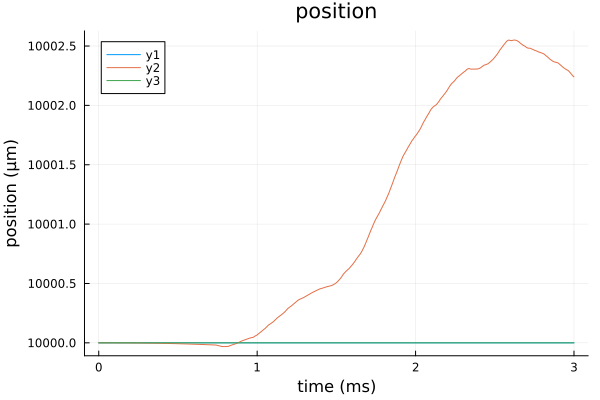

In [33]:
# plot_us = p.extra_p.trajectory
# plot_ts =(dT*save_every : dT*save_every : length(p.extra_p.trajectory)*dT*save_every);

plot()
for i in n_states + length(excited_states) +1 :n_states + length(excited_states) + 3
    plot!(plot_ts/Γ*1e3, [real(u[i]) for u in plot_us]./k*1e6)
end
plot!(legend=true, title="position", xlabel="time (ms)",ylabel="position (μm)")

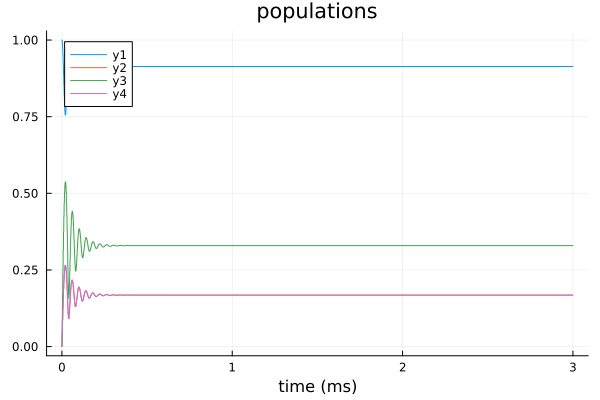

In [34]:
plot_us = sol.u[1:1000:end]
plot_ts = sol.t[1:1000:end]

plot()
for i in 1:n_states
    plot!(plot_ts/Γ*1e3, [norm(sol.u[j][i]) for j in eachindex(plot_us)])
end
plot!(legend=true, title="populations", xlabel="time (ms)")

In [ ]:
plot_us = sol.u[1:1:end]
plot_ts = sol.t[1:1:end]

plot()

plot!(plot_ts/Γ*1e3, [norm(sol.u[j][end-1]) for j in eachindex(plot_us)])

plot!(legend=true, title="force", xlabel="time (ms)")

In [ ]:
[norm(sol.u[j][end-2]) for j in eachindex(plot_us)]

In [ ]:
import OpticalBlochEquations.ψ_stochastic!
function ψ_stochastic!(dψ, ψ, p, τ)
    @unpack ψ_soa, dψ_soa, r, H₀, ω, fields, H, E_k, ds, ds_state1, ds_state2, Js, eiωt, states, extra_p, mass = p
    
    n_states = length(states)
    n_excited = extra_p.n_excited
    
    r = SVector(real(ψ[n_states + n_excited + 1]), real(ψ[n_states + n_excited + 2]), real(ψ[n_states + n_excited + 3]))

    ψ_norm = 0.0
    for i ∈ 1:n_states
        ψ_norm += norm(ψ[i])^2
    end
    ψ_norm = sqrt(ψ_norm)
    for i ∈ 1:n_states
        ψ[i] /= ψ_norm
    end
    
    base_to_soa!(ψ, ψ_soa)
    
    update_H!(p, τ, r, H₀, fields, H, E_k, ds, ds_state1, ds_state2, Js)
    
    update_eiωt!(eiωt, ω, τ)
    Heisenberg!(H, eiωt)

    mul_by_im_minus!(ψ_soa)
    mul_turbo!(dψ_soa, H, ψ_soa)
    
    soa_to_base!(dψ, dψ_soa)
    
    # calculate force
    f = force_stochastic(E_k, ds, ds_state1, ds_state2, ψ_soa, eiωt)
    # accumulate excited state populations
    for i ∈ 1:n_excited
        dψ[n_states + i] = norm(ψ[n_states-n_excited + i])^2
    end
    
    for i ∈ 1:3
        dψ[n_states + n_excited + i] = ψ[n_states + n_excited + i + 3] # update position
        dψ[n_states + n_excited + i + 3] = f[i]/mass # update velocity
    end

    ψ[end-2:end] .= f
    dψ[end-2:end] .= 0
    
    return nothing
end

In [ ]:
# Multiplication using `@turbo` from LoopVectorization
function mul_turbo!(C, A, B)
    @turbo for m ∈ 1:size(A,1), n ∈ 1:size(B,2)
        Cmn_re = 0.0
        Cmn_im = 0.0
        for k ∈ 1:size(A,2)
            A_mk_re = A.re[m,k]
            A_mk_im = A.im[m,k]
            B_kn_re = B.re[k,n]
            B_kn_im = B.im[k,n]
            Cmn_re += A_mk_re * B_kn_re - A_mk_im * B_kn_im
            Cmn_im += A_mk_re * B_kn_im + A_mk_im * B_kn_re
        end
        C.re[m,n] = Cmn_re
        C.im[m,n] = Cmn_im
    end
end

function mul_by_im!(C::StructArray{<:Complex})
    @turbo for i ∈ eachindex(C)
        a = C.re[i]
        C.re[i] = -C.im[i]
        C.im[i] = a
    end
end

function mul_by_im_minus!(C::StructArray{<:Complex})
    @turbo for i ∈ eachindex(C)
        a = C.re[i]
        C.re[i] = C.im[i]
        C.im[i] = -a
    end
end

function soa_to_base!(ρ::Array{<:Complex}, ρ_soa::StructArray{<:Complex})
    @inbounds for i in eachindex(ρ_soa)
        ρ[i] = ρ_soa.re[i] + im * ρ_soa.im[i]
    end
    return nothing
end

function base_to_soa!(ρ::Array{<:Complex}, ρ_soa::StructArray{<:Complex})
    @inbounds for i in eachindex(ρ_soa)
        ρ_soa.re[i] = real(ρ[i])
        ρ_soa.im[i] = imag(ρ[i])
    end
    return nothing
end

function base_to_soa_vec!(ρ::Array{<:Complex}, ρ_soa::StructArray{<:Complex})
    @inbounds for i in eachindex(ρ, ρ_soa)
        ρ_soa.re[i] = real(ρ[i])
        ρ_soa.im[i] = imag(ρ[i])
    end
    return nothing
end

function update_eiωt!(eiωt::StructArray{<:Complex}, ω::Array{<:Real}, τ::Real)
    @turbo for i ∈ eachindex(ω)
        eiωt.im[i], eiωt.re[i] = sincos( ω[i] * τ )
    end
    return nothing
end

function force_stochastic(E_k, ds, ds_state1, ds_state2, ψ_soa, eiωt)
    F = @SVector Complex{Float64}[0,0,0]

    @inbounds for q ∈ 1:3
        ds_q = ds[q]
        ds_q_re = ds_q.re
        ds_q_im = ds_q.im
        ds_state1_q = ds_state1[q]
        ds_state2_q = ds_state2[q]
        for k ∈ 1:3
            E_kq = E_k[k][q]
            E_kq_re = real(E_kq)
            E_kq_im = imag(E_kq)
            F_k_re = 0.0
            F_k_im = 0.0
            for j ∈ eachindex(ds_q)
                m = ds_state1_q[j] # excited state
                n = ds_state2_q[j] # ground state
                
                # construct ρ_mn = c_m c_n^*
                ρ_mn = conj(ψ_soa[n]*eiωt[n]) * ψ_soa[m]*eiωt[m]

                # c_m = ψ_soa[m] * conj(eiωt[m]) # exp(-iωt) factor to transform to Heisenberg picture
                # c_n = ψ_soa[n] * conj(eiωt[n]) # exp(-iωt) factor to transform to Heisenberg picture

                # ρ_mn = c_m * conj(c_n)

                ρ_re = real(ρ_mn)
                ρ_im = imag(ρ_mn)
                
                d_re = ds_q_re[j]
                d_im = ds_q_im[j]
                d_im = -d_im
                a1 = d_re * ρ_re - d_im * ρ_im
                a2 = d_re * ρ_im + d_im * ρ_re
                F_k_re += E_kq_re * a1 - E_kq_im * a2
                F_k_im += E_kq_im * a1 + E_kq_re * a2     
            end
            F += (im * F_k_re - F_k_im) * ê[k] # multiply by im
        end
    end
    F += conj(F)
    return real.(F)
end
